## Notebook Setup

https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [3]:
#Read in the upsampled data
adult_all_upsampled = pd.read_csv('/content/drive/MyDrive/Team Gogurt Capstone/CA Data/adult_all_upsampled_levels.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,19,20,22,23,24,30,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features = ['RACE - UCLA CHPR DEFINITION, UNABRIDGED (PUF 1 YR RECODE)', 'EDUCATIONAL ATTAINMENT (PUF 1 YR RECODE)',
            'RURAL AND URBAN - CLARITAS (BY CENSUS TRACT) (6 LVLS)', 'BORN IN U.S.', 'LEVEL OF ENGLISH PROFICIENCY: GENERAL ', 'SELF-REPORTED AGE (PUT 1 YR RECODE)',
            'SELF-REPORTED GENDER', 'WORKING STATUS (PUF 1 YR RECODE)','COVERED BY MEDI-CAL',
            'MARITAL STATUS- 4 CATEGORIES']

## Pre-processing

In [5]:
#Encoding
encoder = OrdinalEncoder()
adult_all_encoded = encoder.fit_transform(adult_all_upsampled[features])
adult_all_encoded = pd.DataFrame(adult_all_encoded, columns=features)
adult_all_encoded = pd.DataFrame(adult_all_encoded)

In [6]:
adult_all_upsampled["FOOD SECURITY STATUS LEVEL"].value_counts()

FOOD SECURITY                 46877
INAPPLICABLE - >=200% FPL     46877
FOOD INSECURITY W/O HUNGER    30490
FOOD INSECURITY W/ HUNGER     16387
Name: FOOD SECURITY STATUS LEVEL, dtype: int64

In [7]:
#1 is food secure and 0 is food insecure 
adult_all_upsampled.loc[adult_all_upsampled['FOOD SECURITY STATUS (2 LVLS)'] == 'FOOD SECURITY', 'FOOD SECURITY STATUS (2 LVLS)'] = 1
adult_all_upsampled.loc[adult_all_upsampled['FOOD SECURITY STATUS (2 LVLS)'] == 'FOOD INSECURITY WITH/ WITHOUT HUNGER', 'FOOD SECURITY STATUS (2 LVLS)'] = 0
adult_all_upsampled.loc[adult_all_upsampled['FOOD SECURITY STATUS (2 LVLS)'] == 'INAPPLICABLE - >=200% FPL', 'FOOD SECURITY STATUS (2 LVLS)'] = 1

In [8]:
adult_all_upsampled.loc[adult_all_upsampled['SERIOUS PSYCHOLOGICAL DISTRESS'] == 'PROXY SKIPPED', 'SERIOUS PSYCHOLOGICAL DISTRESS'] = -1

In [9]:
adult_all_upsampled['SERIOUS PSYCHOLOGICAL DISTRESS'] = adult_all_upsampled['SERIOUS PSYCHOLOGICAL DISTRESS'].astype("float")

In [10]:
adult_all_encoded["SERIOUS PSYCHOLOGICAL DISTRESS"] = adult_all_upsampled["SERIOUS PSYCHOLOGICAL DISTRESS"]

## 1st Model: Logistic Regression for Food Secure vs. Food Insecure

In [11]:
X = adult_all_encoded
y = adult_all_upsampled['FOOD SECURITY STATUS (2 LVLS)'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2, stratify=y)
lr = LogisticRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [12]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.62      0.40      0.49      9376
           1       0.75      0.88      0.81     18751

    accuracy                           0.72     28127
   macro avg       0.68      0.64      0.65     28127
weighted avg       0.70      0.72      0.70     28127



In [13]:
print('Confusion Matrix - Test Dataset')
df1 = pd.crosstab(y_test.ravel(), preds, rownames = ['True'], colnames = ['Predicted'], margins = True)
df1

Confusion Matrix - Test Dataset


Predicted,0,1,All
True,,,
0,3770,5606,9376
1,2306,16445,18751
All,6076,22051,28127


### Plotting ROC Curve

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 16445
False Positives: 5606
True Negatives: 3770
False Negatives: 2306


In [15]:
#estimating probabilities for food secure class only 
probas = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probas)

In [16]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99957338, 0.99978669,
       1.        ])

In [17]:
tpr

array([0.00000000e+00, 5.33304890e-05, 7.46626847e-04, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

In [18]:
thresholds

array([1.94280783, 0.94280783, 0.93414368, ..., 0.06355354, 0.05695483,
       0.05622512])

In [19]:
#convert predictions according to various threshold rates
#def get_preds(threshold, probabilities):
 #   return [1 if prob > threshold else 0 for prob in probabilities]

In [20]:
logit_roc_auc1 = roc_auc_score(y_test, preds)

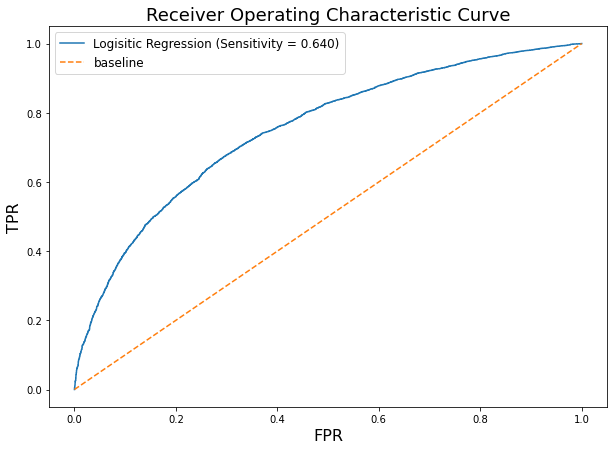

In [21]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr, label = 'Logisitic Regression (Sensitivity = %0.3f)' % logit_roc_auc1)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)

In [22]:
y_pred_prob = lr.predict_proba(X_test)[:,1]
y_pred_prob = y_pred_prob.reshape(1, -1)
y_pred_prob

array([[0.90672556, 0.66236192, 0.60342556, ..., 0.61754056, 0.65705683,
        0.88917009]])

### Adjusting Threshold of LR Model

**following cell can change the number after `y_pred_prob` to see impact of threshold**

In [23]:
#changing the threshold and seeing the impact on the precision

from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob, 0.82)[0]

In [24]:
y_pred_class = y_pred_class.astype(int)

In [25]:
confusion_matrix2 = confusion_matrix(y_test, y_pred_class)
print(confusion_matrix2)

[[ 8421   955]
 [11257  7494]]


In [26]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.43      0.90      0.58      9376
           1       0.89      0.40      0.55     18751

    accuracy                           0.57     28127
   macro avg       0.66      0.65      0.57     28127
weighted avg       0.73      0.57      0.56     28127



In [27]:
print('Adjusted Confusion Matrix - Test Dataset')
df2 = pd.crosstab(y_test.ravel(), y_pred_class, rownames = ['True'], colnames = ['Predicted'], margins = True)
df2

Adjusted Confusion Matrix - Test Dataset


Predicted,0,1,All
True,,,
0,8421,955,9376
1,11257,7494,18751
All,19678,8449,28127


In [28]:
logit_roc_auc2 = roc_auc_score(y_test, y_pred_class)

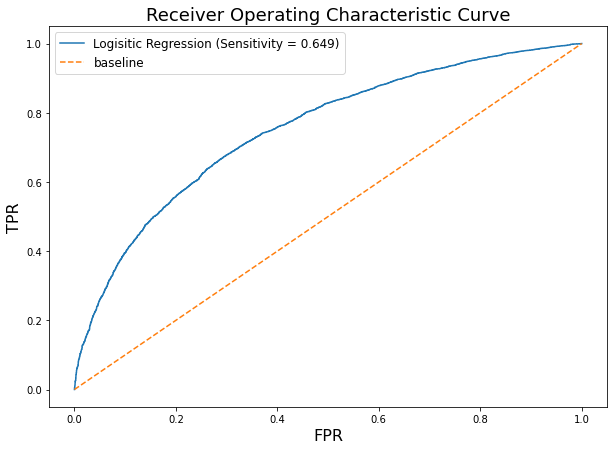

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr, tpr, label = 'Logisitic Regression (Sensitivity = %0.3f)' % logit_roc_auc2)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12)

https://intellipaat.com/blog/roc-curve-in-machine-learning/

In [30]:
#roc_values = []
#for thresh in np.linspace(0, 1, 100):
 #   preds = get_preds(thresh, probas)
  #  tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
   # tpr = tp/(tp+fn)
    #fpr = fp/(fp+tn)
    #roc_values.append([tpr, fpr])
#tpr_values, fpr_values = zip(*roc_values)

## 2nd Model: Multiclass XGBoost Model

In [31]:
adult_all_upsampled_2 = pd.read_csv('/content/drive/MyDrive/Team Gogurt Capstone/CA Data/adult_all_upsampled_three_levels.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,19,20,22,23,24,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# Create Subset of Testset where LR model classified as Food Insecure
X_test_negative = X_test[y_pred_class == 0]
X_test_negative.index
y_test_negative = adult_all_upsampled_2['FOOD SECURITY STATUS LEVEL'][X_test.index][y_pred_class == 0]

In [33]:
y_second = adult_all_upsampled_2['FOOD SECURITY STATUS LEVEL']
y_train_2 = y_second.iloc[X_train.index]
y_test_2 = y_second.iloc[X_test.index]

In [34]:
multi_class_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [35]:
"""
multi_class_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)
"""

"\nmulti_class_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, gamma=0,\n              learning_rate=0.1, max_delta_step=0, max_depth=9,\n              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,\n              nthread=4, num_class=3, objective='multi:softprob',\n              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n              seed=42, silent=None, subsample=1, verbosity=1)\n"

In [36]:
multi_class_model.fit(X_train, y_train_2)
y_pred_second = multi_class_model.predict(X_test_negative)

In [37]:
# Classification Report on Subset using Both LR and XGB Models
print(classification_report(y_test_negative, y_pred_second))

               precision    recall  f1-score   support

FOOD INSECURE       0.83      0.89      0.86      8421
FOOD SECURITY       0.81      0.79      0.80      7100
 INAPPLICABLE       0.76      0.67      0.71      4157

     accuracy                           0.81     19678
    macro avg       0.80      0.79      0.79     19678
 weighted avg       0.81      0.81      0.81     19678



In [38]:
print('Confusion Matrix for Subset of Test Dataset using Both Models')
df3 = pd.crosstab(y_test_negative.ravel(), y_pred_second, rownames = ['True'], colnames = ['Predicted'], margins = True)
df3

Confusion Matrix for Subset of Test Dataset using Both Models


Predicted,FOOD INSECURE,FOOD SECURITY,INAPPLICABLE,All
True,,,,
FOOD INSECURE,7527,573,321,8421
FOOD SECURITY,895,5635,570,7100
INAPPLICABLE,623,753,2781,4157
All,9045,6961,3672,19678


In [39]:
y_pred_original = multi_class_model.predict(X_test)

In [40]:
# Classification Report on Original Testset using only XGB (part 2)
print(classification_report(y_test_2, y_pred_original))

               precision    recall  f1-score   support

FOOD INSECURE       0.83      0.85      0.84      9376
FOOD SECURITY       0.78      0.72      0.75      9380
 INAPPLICABLE       0.76      0.81      0.78      9371

     accuracy                           0.79     28127
    macro avg       0.79      0.79      0.79     28127
 weighted avg       0.79      0.79      0.79     28127



In [41]:
print('Confusion Matrix for Original Test Dataset using only Model 2')
df4 = pd.crosstab(y_test_2.ravel(), y_pred_original, rownames = ['True'], colnames = ['Predicted'], margins = True)
df4

Confusion Matrix for Original Test Dataset using only Model 2


Predicted,FOOD INSECURE,FOOD SECURITY,INAPPLICABLE,All
True,,,,
FOOD INSECURE,7965,711,700,9376
FOOD SECURITY,926,6735,1719,9380
INAPPLICABLE,668,1140,7563,9371
All,9559,8586,9982,28127


## Saving models

In [42]:
import pickle

In [43]:
# save the models to disk
model_1 = 'model_1.pickle'
pickle.dump(lr, open(model_1, 'wb'))

model_2 = 'model_2.pickle'
pickle.dump(multi_class_model, open(model_2, 'wb'))

In [44]:
# load the models from disk
loaded_model_1 = pickle.load(open(model_1, 'rb'))

loaded_model_2 = pickle.load(open(model_2, 'rb'))

## Test User

In [45]:
all_features = ['RACE - UCLA CHPR DEFINITION, UNABRIDGED (PUF 1 YR RECODE)', 'EDUCATIONAL ATTAINMENT (PUF 1 YR RECODE)',
            'RURAL AND URBAN - CLARITAS (BY CENSUS TRACT) (6 LVLS)', 'BORN IN U.S.', 'LEVEL OF ENGLISH PROFICIENCY: GENERAL ', 'SELF-REPORTED AGE (PUT 1 YR RECODE)',
            'SELF-REPORTED GENDER', 'WORKING STATUS (PUF 1 YR RECODE)','COVERED BY MEDI-CAL',
            'MARITAL STATUS- 4 CATEGORIES', "SERIOUS PSYCHOLOGICAL DISTRESS"]

In [47]:
X_test[95:100]

,"RACE - UCLA CHPR DEFINITION, UNABRIDGED (PUF 1 YR RECODE)",EDUCATIONAL ATTAINMENT (PUF 1 YR RECODE),RURAL AND URBAN - CLARITAS (BY CENSUS TRACT) (6 LVLS),BORN IN U.S.,LEVEL OF ENGLISH PROFICIENCY: GENERAL,SELF-REPORTED AGE (PUT 1 YR RECODE),SELF-REPORTED GENDER,WORKING STATUS (PUF 1 YR RECODE),COVERED BY MEDI-CAL,MARITAL STATUS- 4 CATEGORIES,SERIOUS PSYCHOLOGICAL DISTRESS
136705,5.0,7.0,2.0,0.0,0.0,12.0,0.0,4.0,0.0,1.0,0.0
102891,4.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,9.0
35594,4.0,2.0,5.0,0.0,0.0,6.0,1.0,2.0,0.0,1.0,4.0
138719,5.0,8.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,6.0
5376,5.0,1.0,3.0,1.0,0.0,7.0,1.0,0.0,1.0,3.0,8.0


In [48]:
y_test_2[95:100]

136705     INAPPLICABLE
102891     INAPPLICABLE
35594     FOOD SECURITY
138719     INAPPLICABLE
5376      FOOD SECURITY
Name: FOOD SECURITY STATUS LEVEL, dtype: object

In [49]:
race = 4
education = 1
city = 8
born = 0
english = 0
age = 0
gender = 2
working = 0
medical = 1
psych = 12
married = 4

In [50]:
dvalues = [race, education, city, born, english, age, gender, working, medical, married, psych]
input_values = dict(zip(all_features, dvalues))

In [51]:
df = pd.DataFrame(input_values, index = [0])
df

,"RACE - UCLA CHPR DEFINITION, UNABRIDGED (PUF 1 YR RECODE)",EDUCATIONAL ATTAINMENT (PUF 1 YR RECODE),RURAL AND URBAN - CLARITAS (BY CENSUS TRACT) (6 LVLS),BORN IN U.S.,LEVEL OF ENGLISH PROFICIENCY: GENERAL,SELF-REPORTED AGE (PUT 1 YR RECODE),SELF-REPORTED GENDER,WORKING STATUS (PUF 1 YR RECODE),COVERED BY MEDI-CAL,MARITAL STATUS- 4 CATEGORIES,SERIOUS PSYCHOLOGICAL DISTRESS
0,4,1,8,0,0,0,2,0,1,4,12


In [52]:
user_pred_prob = loaded_model_1.predict_proba(df)[:,1]
user_pred_prob = user_pred_prob.reshape(1, -1)
user_pred_prob

array([[0.31569516]])

In [53]:
user_pred_class = binarize(user_pred_prob, 0.82)[0]
user_pred_class.astype(int)

array([0])

In [54]:
user_pred_second = loaded_model_2.predict(df)
user_pred_second

array(['INAPPLICABLE'], dtype=object)

In [55]:
user_pred_class[0]

0.0

In [56]:
if user_pred_class[0] == 1:
    print("Food Secure")
else:
    user_pred_second = multi_class_model.predict(df)
    print(user_pred_second[0])

INAPPLICABLE
